In [1]:
import os
import pandas as pd
import numpy as np
import torch

from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import sys

sys.path.append("../..")

from src.physics_dataset import PhysicsStatesDataset
from src.ai_models import FullyConnectedCtrl, CasadiModel

In [2]:
dataset = PhysicsStatesDataset("../../data/raw/cart_pole/20231006145359627330.csv")

# dataset.join_dataframe("../../data/raw/cart_pole/20231006145432781317.csv")

dataset.dataframe.head()

,id,time,qpos,qvel,qacc,ctrl
0,0,0.002,"[0.0, 0.0]","[0.0, 0.0]","[0.0, 0.0]","[0.0, 0.0]"
1,1,0.004,"[1.19646578e-10, 7.28605007e-10]","[5.98232892e-08, 3.64302504e-07]","[2.99116446e-05, 0.000182151252]","[9.99983333e-05, 9.99983333e-05]"
2,2,0.006,"[7.17845414e-10, 4.37140331e-09]","[2.99099418e-07, 1.82139915e-06]","[0.00011964, 0.00072855]","[0.00039997, 0.00039997]"
3,3,0.008,"[2.39265913e-09, 1.45702863e-08]","[8.37406857e-07, 5.09944152e-06]","[0.00026915, 0.00163902]","[0.00089987, 0.00089987]"
4,4,0.010,"[5.98113704e-09, 3.64223153e-08]","[1.79423896e-06, 1.09260145e-05]","[0.00047842, 0.00291329]","[0.00159957, 0.00159957]"


In [3]:
from sklearn.model_selection import train_test_split

proportion = 0.2
x_train, x_test, y_train, y_test = train_test_split(
    dataset.states.float(), dataset.ctrls.float(), test_size=proportion, random_state=42
)

In [4]:
train_loader = DataLoader(
    TensorDataset(torch.tensor(x_train), torch.tensor(y_train)),
    batch_size=20,
    shuffle=True,
)
val_loader = DataLoader(
    TensorDataset(torch.tensor(x_test), torch.tensor(y_test)),
    batch_size=20,
    shuffle=True,
)

/tmp/ipykernel_22674/3394741560.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  TensorDataset(torch.tensor(x_train), torch.tensor(y_train)),
/tmp/ipykernel_22674/3394741560.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  TensorDataset(torch.tensor(x_test), torch.tensor(y_test)),


In [5]:
y_test

tensor([[ 9.6463,  9.6463],
        [17.1924, 17.1924],
        [26.1315, 26.1315],
        ...,
        [21.2909, 21.2909],
        [22.2912, 22.2912],
        [ 7.6851,  7.6851]])

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = FullyConnectedCtrl(
    nv=2,
    ctrl=2,
    linear_layers=3,
    linear_hidden_size=100,
).to(device)

In [7]:
model.load_state_dict(torch.load("../../data/models/cartpole_fc.pt"))

<All keys matched successfully>

In [8]:
# _, val_losses = model.train_model(
#     train_loader,
#     val_loader,
#     epochs=30,
#     ckpt_path="../../data/models/cartpole_fc.pt",
# )


In [9]:
# plt.title("Validation losses")
# plt.plot(val_losses)
# plt.grid()
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.show()

In [10]:
model(torch.tensor([0, 0, 0, 0, 0, 0], dtype=torch.float))

tensor([-0.1051, -0.1090], grad_fn=<ViewBackward0>)

In [11]:
casadi_model = CasadiModel(model)

In [12]:
casadi_model(np.array([0, 0, 0, 0, 0, 0]))

DM([[-0.105101, -0.109014]])

# Trajectory optimization

In [13]:
import casadi as cs

cart0 = 0
cartfinal = 0
angle0 = 0
anglefinal = cs.pi

In [14]:
# formulate problem

opti = cs.Opti()

T = 3
N = T * 200

x = opti.variable(N, 6)
q = x[:, :2]
dq = x[:, 2:4]
ddq = x[:, 4:]

In [15]:
q[0, :].shape

(1, 2)

In [16]:
opti.subject_to(q[0, :].T == [cart0, angle0])
opti.subject_to(q[-1, :].T == [cartfinal, anglefinal])

opti.set_initial(q[:, 0], cs.linspace(cart0, cartfinal, N))
opti.set_initial(dq[:, 0], (cartfinal - cart0) / T)
opti.set_initial(ddq[:, 0], (cartfinal - cart0) / T**2)

opti.subject_to(dq[0, :] == 0)
opti.subject_to(dq[-1, :] == 0)

opti.subject_to(ddq[-1, :] == 0)
opti.subject_to(ddq[0, :] == 0)

In [17]:
casadi_model(x[0, :])

MX(inference(opti0_x_1[:3600:600]){0})

In [18]:
# integration constraints
dt = T / N

for i in range(N - 1):
    opti.subject_to(q[i + 1] == q[i] + dt * dq[i + 1])
    opti.subject_to(dq[i + 1] == dq[i] + dt * ddq[i])

cost = 0

# dynamics constraints
for i in range(N - 1):
    u = casadi_model(x[i, :])

    # # constraint might come from our motor possibilites
    opti.subject_to(opti.bounded(-30, u, 30))

    cost += 1 * u[0] ** 2 + 100 * u[1] ** 2

opti.minimize(cost)

In [19]:
opti.solver("ipopt")
opti.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3606
Number of nonzeros in inequality constraint Jacobian.:     7188
Number of nonzeros in Lagrangian Hessian.............:    12579

Total number of variables............................:     3600
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1210
Total number of inequality c

OptiSol(Opti {
  instance #0
  #variables: 1 (nx = 3600)
  #parameters: 0 (np = 0)
  #constraints: 1803 (ng = 2408)
  CasADi solver allocated.
  CasADi solver was called: Solve_Succeeded
})

In [20]:
q, dq, ddq = opti.value(q), opti.value(dq), opti.value(ddq)

Text(0, 0.5, 'Angle [rad]')

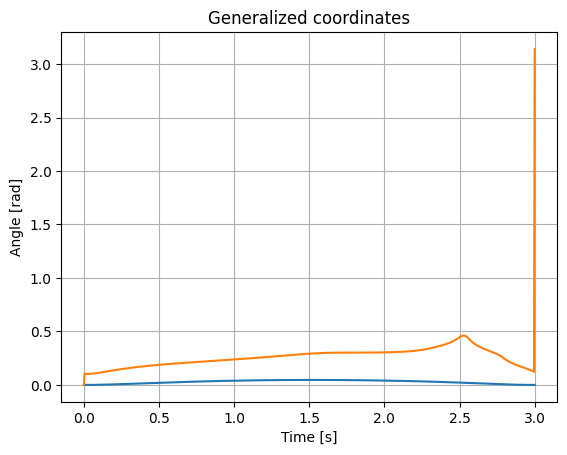

In [21]:
from matplotlib import pyplot as plt

timeseries = cs.linspace(0, T, N)

plt.title("Generalized coordinates")
plt.grid()
plt.plot(timeseries, q)
plt.xlabel("Time [s]")
plt.ylabel("Angle [rad]")

Text(0, 0.5, 'Velocity [rad/s]')

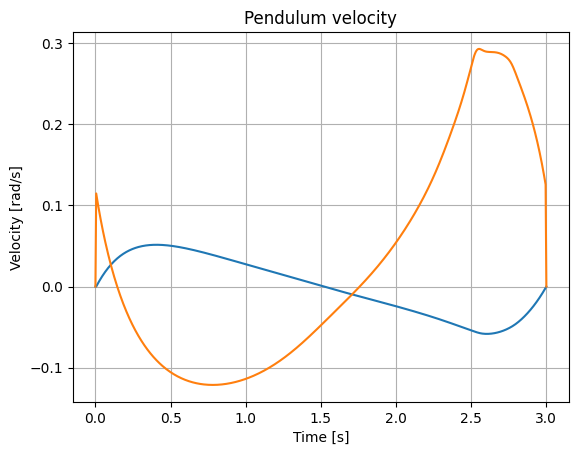

In [22]:
from matplotlib import pyplot as plt

timeseries = cs.linspace(0, T, N)

plt.title("Pendulum velocity")
plt.grid()
plt.plot(timeseries, dq)
plt.xlabel("Time [s]")
plt.ylabel("Velocity [rad/s]")

Text(0, 0.5, 'Acceleration [rad/s^2]')

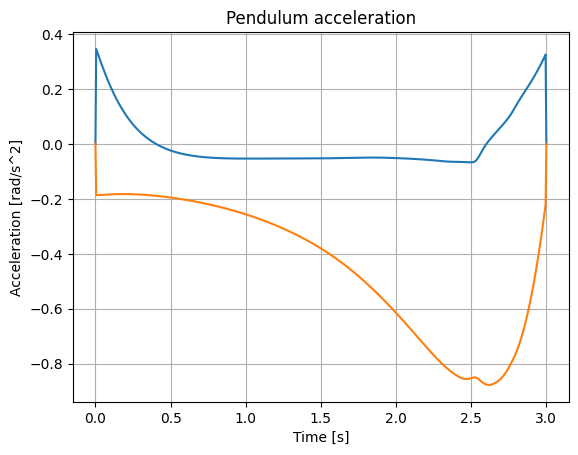

In [23]:
from matplotlib import pyplot as plt

timeseries = cs.linspace(0, T, N)

plt.title("Pendulum acceleration")
plt.grid()
plt.plot(timeseries, ddq)
plt.xlabel("Time [s]")
plt.ylabel("Acceleration [rad/s^2]")